# Noise Hamming weight and Pearson Correlation

This notebook demonstrates how to guess a floating number using Hamming Weight model.

We generate a random secret floating number. Then we use hamming weight model to guess the number.

In [236]:
import numpy as np
import pandas as pd
from pprint import pprint
from guess_range import *
from batina_guess_number import *

## Visualize HW Behavior

In [237]:
def compute_corr(secret_hw, guess_range, known_inputs, guess_val_size=1000):
    low, high = guess_range
    guess_val = np.arange(low, high, (high - low) / (guess_val_size - 1e-127))
    hw = pd.DataFrame(columns=guess_val,
                        data=np.vectorize(hamming_weight)(known_inputs.reshape(-1, 1) * guess_val))
    return hw.corrwith(pd.Series(secret_hw), method='pearson')

In [238]:
guess_range=(0.0, 5.0)
# the number of guess values in the guess range
guess_val_size=200
# generate the known inputs which is used to test the guess values
input_range = 2
known_inputs = np.random.uniform(-10 ** input_range, 10 ** input_range, 1000)

secret_number = np.random.uniform(guess_range[0], guess_range[1]) 
secret_number = 0.21265756
print('secret_number =', secret_number)

secret_number = 0.21265756


In [239]:
secret_hw = np.vectorize(hamming_weight)(known_inputs * secret_number)
correlations = compute_corr(secret_hw, guess_range, known_inputs, guess_val_size)
correlations_1 = compute_corr(secret_hw, guess_range, known_inputs, int(guess_val_size*10))
correlations_2 = compute_corr(secret_hw, guess_range, known_inputs, int(guess_val_size/10))
correlations_1.sort_values(ascending=False).iloc[:10]

3.4025    0.518992
0.2125    0.510412
0.8500    0.370456
0.4250    0.338474
3.4000    0.334790
0.2100    0.318890
0.2000    0.308404
0.2275    0.293338
0.2225    0.293090
1.7000    0.292966
dtype: float64

In [240]:
i = correlations_1.sort_values(ascending=False).index
a = np.logical_and((i > 0.62),  (i < 0.63))
b = np.logical_and(a, correlations_1>0.6)
i[b]

Float64Index([], dtype='float64')

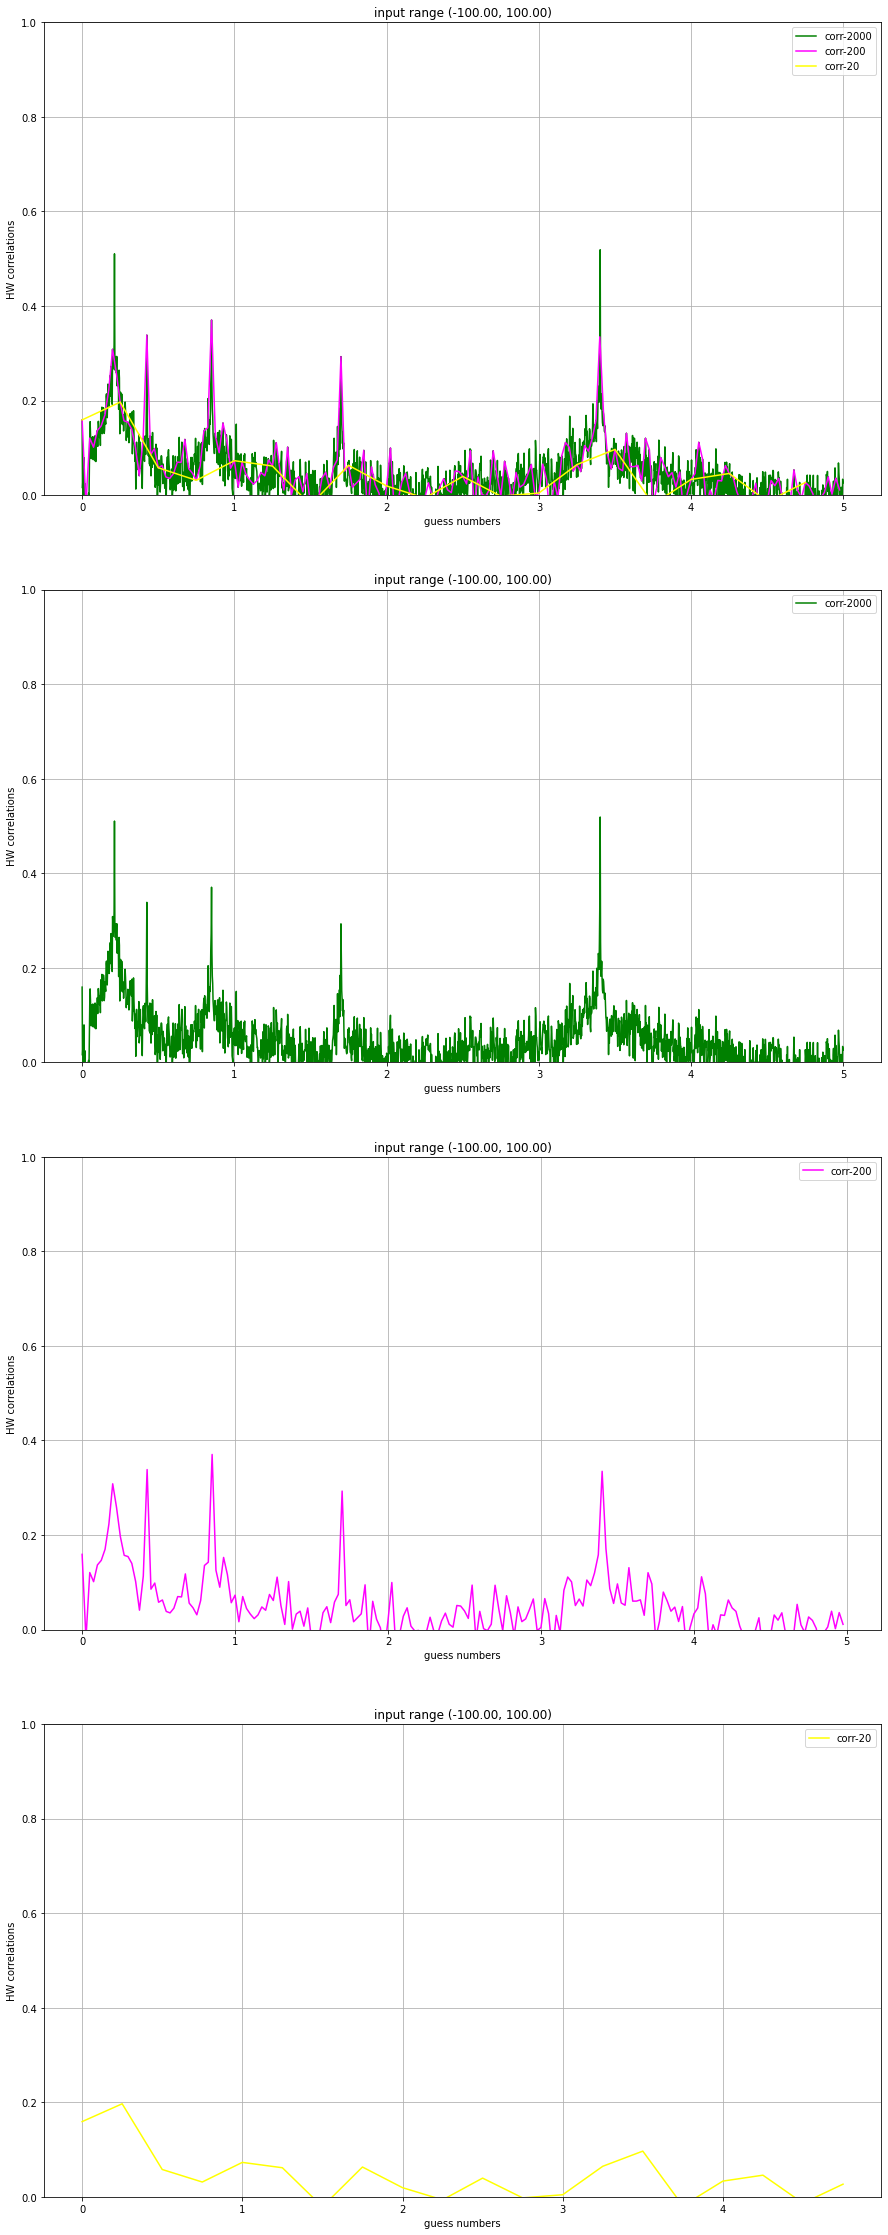

In [241]:
show_secret_line = False


from matplotlib import pyplot as plt
fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(15, 40))
correlations_1.plot(ax=ax[0], label='corr-%s' % correlations_1.shape[0], color='green')
correlations.plot(ax=ax[0], label='corr-%s' % correlations.shape[0], color='magenta')
correlations_2.plot(ax=ax[0], label='corr-%s' % correlations_2.shape[0], color='yellow')

correlations_1.plot(ax=ax[1], label='corr-%s' % correlations_1.shape[0], color='green')

correlations.plot(ax=ax[2], label='corr-%s' % correlations.shape[0], color='magenta')

correlations_2.plot(ax=ax[3], label='corr-%s' % correlations_2.shape[0], color='yellow')

for a in ax:
    if show_secret_line and ((guess_range[0] <= secret_number) and (secret_number < guess_range[1])):
        a.vlines(secret_number, min(0, correlations.min()), max(correlations.max(),0), color='red', label='secret value')
    a.set_ylim(0.0, 1.0)
    a.legend()
    a.grid(True)
    a.set_xlabel('guess numbers')
    a.set_ylabel('HW correlations')
    a.set_title('input range (%.02f, %.02f)' % (-10 ** input_range, 10 ** input_range))
    
plt.show()

## Correlation of mantissa

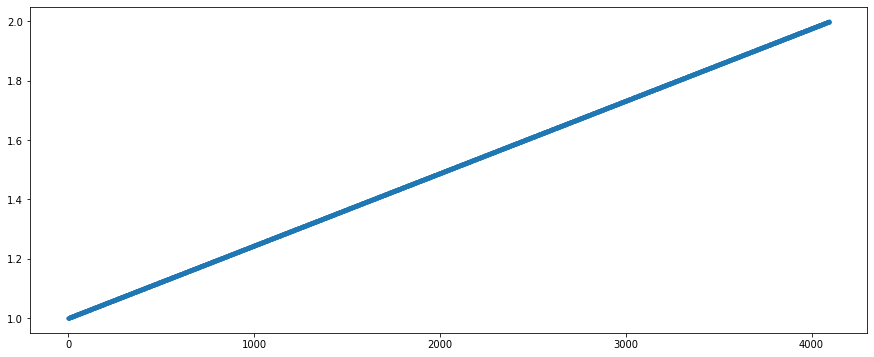

In [242]:
mantissa_nbits = 12
guess_numbers = build_guess_values(value_type='mantissa', mantissa_nbits=mantissa_nbits, guess_range=guess_range)
pd.Series(guess_numbers).sort_values().reset_index(drop=True).plot(figsize=(15,6), marker='.')

In [243]:
mantissa_processing_func = lambda x: bin(float_to_int(x) & 0x7fffff).count('1')

In [244]:
mantisa_corr = compute_corr_numbers(secret_hw, known_inputs, guess_numbers, processing_func=mantissa_processing_func)

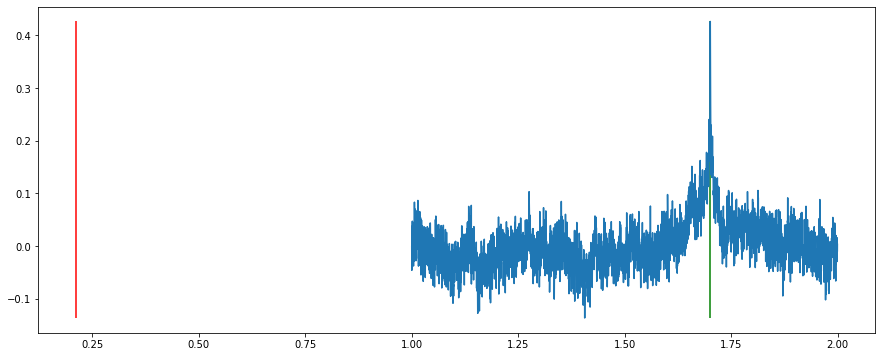

In [245]:
ax = mantisa_corr.sort_index().plot(figsize=(15,6))
ax.vlines(mantisa_corr.idxmax(), mantisa_corr.min(), mantisa_corr.max(), color='green')
ax.vlines(secret_number, mantisa_corr.min(), mantisa_corr.max(), color='red')

In [246]:
mantisa_corr.sort_values(ascending=False).iloc[:10]

1.701172    0.426564
1.701416    0.352922
1.700928    0.331765
1.700684    0.324683
1.701660    0.282779
1.701904    0.274345
1.702148    0.247350
1.698486    0.240604
1.700439    0.234530
1.703125    0.229944
dtype: float64

## Correlation exponent

/home/tvk/programming/others/DPACv4/batina_guess_number.py:31: RuntimeWarning: invalid value encountered in less_equal
  guess_numbers = y[(lo_range <= y) & (y <= hi_range)]


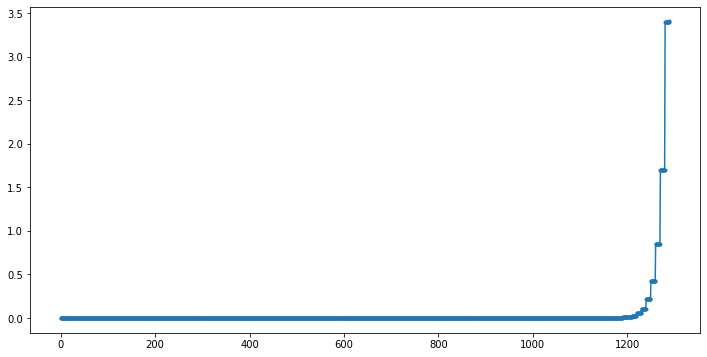

In [247]:
guess_numbers = build_guess_values(value_type='exponent', numbers=mantisa_corr.sort_values(ascending=False).index[:10], guess_range=guess_range)
pd.Series(guess_numbers).sort_values().reset_index(drop=True).plot(figsize=(12,6), marker='.')

In [248]:
mantisa_exp_corr = compute_corr_numbers(secret_hw, known_inputs, guess_numbers, processing_func=None)

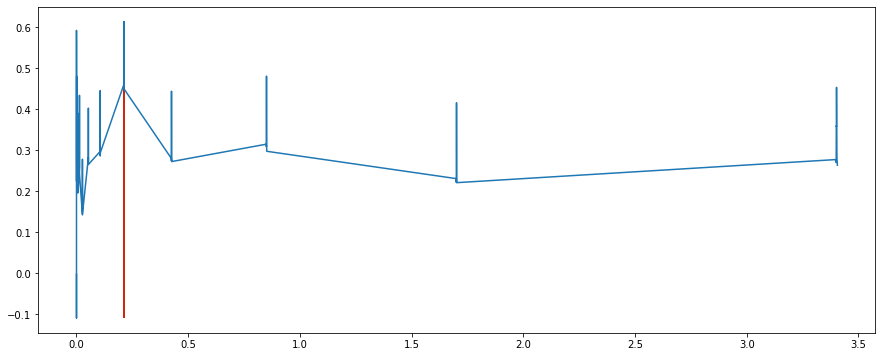

In [249]:
ax = mantisa_exp_corr.sort_index().plot(figsize=(15,6))
ax.vlines(mantisa_exp_corr.idxmax(), mantisa_exp_corr.min(), mantisa_exp_corr.max(), color='green')
ax.vlines(secret_number, mantisa_exp_corr.min(), mantisa_exp_corr.max(), color='red')

In [250]:
mantisa_exp_corr.sort_values(ascending=False).iloc[:10]

2.126465e-01    0.614470
1.152759e-20    0.592717
2.126770e-01    0.564493
2.683976e-30    0.563301
4.951062e-11    0.563301
1.152924e-20    0.540757
2.126160e-01    0.538485
2.125854e-01    0.526136
4.095422e-35    0.525713
7.554721e-16    0.525713
dtype: float64

## Correlation sign

array([2.12646484e-01, 1.15275890e-20, 2.12677002e-01, 2.68397597e-30,
       4.95106178e-11, 1.15292434e-20, 2.12615967e-01, 2.12585449e-01,
       4.09542232e-35, 7.55472074e-16])

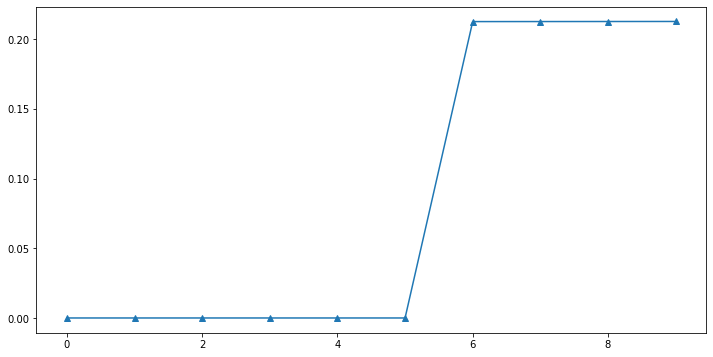

In [251]:
guess_numbers = build_guess_values(value_type='sign', numbers=mantisa_exp_corr.sort_values(ascending=False).index[:10], guess_range=guess_range)
pd.Series(guess_numbers).sort_values().reset_index(drop=True).plot(figsize=(12,6), marker='^')
guess_numbers

In [252]:
full_number_corr = compute_corr_numbers(secret_hw, known_inputs, guess_numbers, processing_func=None)

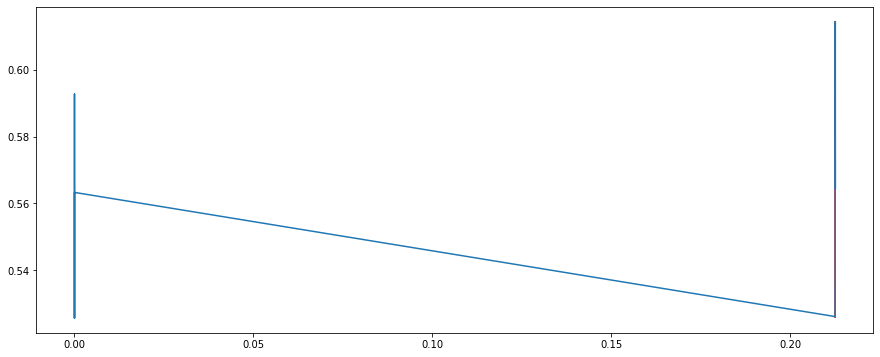

In [253]:
ax = full_number_corr.sort_index().plot(figsize=(15,6))
ax.vlines(secret_number, full_number_corr.min(), full_number_corr.max(), color='red')

In [254]:
full_number_corr.sort_values(ascending=False).iloc[:10]

2.126465e-01    0.614470
1.152759e-20    0.592717
2.126770e-01    0.564493
4.951062e-11    0.563301
2.683976e-30    0.563301
1.152924e-20    0.540757
2.126160e-01    0.538485
2.125854e-01    0.526136
7.554721e-16    0.525713
4.095422e-35    0.525713
dtype: float64

## Recover a secret number

In [258]:
%%time
for i in range(10):
    full_number_corr = batina_recover_weight(weight_hw=secret_hw, known_inputs=known_inputs, guess_range=guess_range)
# ax = full_number_corr.sort_index().plot(figsize=(15,6))
# ax.vlines(secret_number, full_number_corr.min(), full_number_corr.max(), color='red')

/home/tvk/programming/others/DPACv4/batina_guess_number.py:31: RuntimeWarning: invalid value encountered in less_equal
  guess_numbers = y[(lo_range <= y) & (y <= hi_range)]


CPU times: user 17.5 s, sys: 172 ms, total: 17.7 s
Wall time: 17.7 s


In [257]:
full_number_corr.sort_values(ascending=False).iloc[:10]

2.126465e-01    0.614470
1.152759e-20    0.592717
2.683976e-30    0.563301
4.951062e-11    0.563301
1.758970e-25    0.525713
4.095422e-35    0.525713
7.554721e-16    0.525713
3.244728e-06    0.525713
2.951063e-18    0.481173
8.505859e-01    0.480971
dtype: float64

## Analyze with noise - one number

In [187]:
def resize_known_inputs(known_inputs, new_len):
    """
    resize the known input to the new_len
    :param known_inputs: known inputs 
    :param new_len: new size of the know_inputs
    :return: the known
    """
    old_len = len(known_inputs)
    vf = np.vectorize(lambda i: known_inputs[int(i*old_len/new_len)])
    return vf(np.arange(0, new_len))

In [188]:
def add_noise_to_signal(signal, snr, freq):
    """
    add noise to the signal
    :param signal: signal
    :param snr: signal to noise ratio 
    :param freq: frequency of noise 
    :return: signal with noise
    """
    sig_max = signal.max()
    sig_min = signal.min()
    return pd.Series(signal).apply(lambda x: x  +
                                   np.average(np.random.normal(0.0, (sig_max-sig_min)/snr, freq)))

In [189]:
# the noise frequency is 50 times higher than HW signal frequency. Here we also increase
# the sizes of the computation with 
no_noise_secret_hw = np.vectorize(hamming_weight)(known_inputs * secret_number)

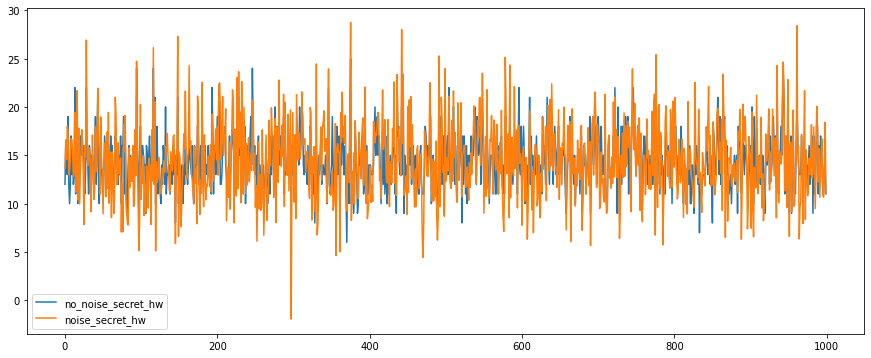

In [190]:
### Add noise to hamming weight of the multiplication of the secret number
signal_to_noise_ratio = 0.5
noise_secret_hw = add_noise_to_signal(signal=no_noise_secret_hw, snr=signal_to_noise_ratio, freq=200)
ax = pd.DataFrame([no_noise_secret_hw, noise_secret_hw], index=['no_noise_secret_hw', 'noise_secret_hw']).T.plot(figsize=(15,6))
ax.legend()

In [191]:
noise_correlations = compute_corr(noise_secret_hw, guess_range, known_inputs, guess_val_size)
print('secret_number =', secret_number)
noise_correlations.sort_values(ascending=False).iloc[:10]

secret_number = 0.21265756


0.200    0.208491
0.425    0.200472
0.225    0.196981
0.175    0.196395
0.150    0.184991
0.850    0.174525
0.125    0.162359
3.400    0.162199
1.700    0.157800
0.100    0.141377
dtype: float64

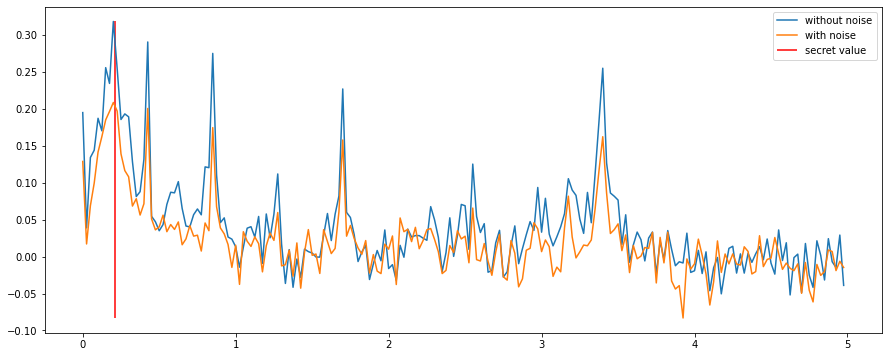

In [192]:
ax = correlations.plot(figsize=(15, 6), label='without noise')
noise_correlations.plot(ax=ax, label='with noise')
ax.vlines(secret_number, 
          min(noise_correlations.min(), correlations.min()),
          max(noise_correlations.max(), correlations.max()), 
          color='red', label='secret value')
ax.legend()

## Analyze with noise - multiple numbers

In [203]:
guess_range = (0.0, 5.0)
known_input_set = generate_known_inputs(exps=(-2,3), nsize=3000)
precision = 1e-6
n_secret_numbers = 100
secret_numbers = np.concatenate((
    np.random.uniform(guess_range[0], guess_range[1], int(n_secret_numbers*2/4) ),
    np.random.uniform(guess_range[0]*3e-1, guess_range[1]*3e-1, int(n_secret_numbers*1/4)),
    np.random.uniform(guess_range[0]*1e-1, guess_range[1]*1e-1, int(n_secret_numbers*1/4))
))
np.random.shuffle(secret_numbers)
print('secret_numbers.shape = %s' % (str(secret_numbers.shape)))

secret_numbers.shape = (100,)


In [204]:
secret_numbers_hws = {}
for idx in known_input_set.index:
    secret_numbers_hws[idx] = pd.DataFrame(
        columns=secret_numbers, 
        data=np.vectorize(hamming_weight)(np.asarray(known_input_set.loc[idx]).reshape(-1, 1) * secret_numbers))

In [205]:
secret_numbers_hws[0]

,0.471970,4.847261,0.169929,0.139822,0.195251,1.030211,1.163834,1.391611,0.347156,0.722797,...,0.431292,2.883776,1.138679,1.528282,1.181079,4.815676,1.725564,1.255066,0.122548,0.493729
0,16,17,17,15,19,18,18,17,17,15,...,13,14,16,21,20,16,20,16,16,20
1,21,11,14,21,15,19,21,18,15,17,...,17,16,18,18,16,11,17,16,16,18
2,21,20,17,18,15,15,19,18,20,14,...,20,20,18,17,21,21,19,16,19,20
3,21,15,18,19,20,18,21,18,23,17,...,18,13,19,18,18,13,22,20,18,21
4,17,18,17,17,17,18,21,20,19,19,...,17,10,18,21,23,16,22,18,17,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,14,17,16,16,13,15,15,20,16,17,...,16,16,12,22,14,16,14,18,15,18
496,17,14,19,17,15,18,23,16,17,21,...,18,12,21,21,18,11,21,18,18,20
497,19,11,17,15,17,20,22,21,20,20,...,16,16,20,21,19,12,20,16,19,21
498,15,19,15,10,17,21,19,18,18,15,...,20,19,16,18,14,14,20,17,18,20


In [206]:
### Add noise to hamming weight of the multiplication of the secret number
signal_to_noise_ratio = 0.5
noise_secret_numbers_hws = {}
for k in secret_numbers_hws.keys():
    noise_secret_numbers_hws[k] = secret_numbers_hws[k].apply(lambda hw: add_noise_to_signal(signal=hw, snr=signal_to_noise_ratio, freq=200), axis=0)
noise_secret_numbers_hws[0]    

,0.471970,4.847261,0.169929,0.139822,0.195251,1.030211,1.163834,1.391611,0.347156,0.722797,...,0.431292,2.883776,1.138679,1.528282,1.181079,4.815676,1.725564,1.255066,0.122548,0.493729
0,13.032680,17.640007,15.448526,13.495773,20.242156,17.153200,14.522798,15.583769,15.667857,16.311996,...,11.631276,15.585568,15.249203,20.846732,20.269834,16.390877,21.152065,13.615265,17.803755,20.486375
1,16.058673,10.171307,11.993746,23.169181,10.269071,17.436296,21.516695,17.636221,13.887515,17.944871,...,16.140676,13.235153,17.621391,16.353270,12.858329,11.554749,16.111814,13.302177,17.502279,18.016889
2,23.458748,15.458195,16.459026,19.858638,13.745686,13.899504,18.341383,19.002706,18.147611,15.195271,...,19.568373,14.608227,16.203148,16.752786,20.559821,19.344675,15.889950,14.900827,17.970762,24.639712
3,18.607444,11.807888,17.390955,19.037252,21.466256,19.047856,21.303403,17.381384,19.664510,20.004601,...,18.469837,10.935505,16.090099,19.653752,16.363103,16.173754,23.515746,21.054768,19.196066,20.208995
4,19.839378,15.913959,14.844756,18.486449,12.077124,16.591372,21.745950,14.390084,14.671729,21.327407,...,15.631977,11.876454,15.891229,21.154362,25.672848,16.612436,24.119270,22.294094,18.567970,14.577832
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,17.392543,15.693406,14.848861,15.732940,13.697984,14.269022,15.247478,18.201600,15.947917,17.769004,...,17.540887,9.796750,18.197008,26.885662,13.799155,14.093212,14.078907,18.365352,18.771537,18.312483
496,18.198945,15.838235,22.224677,18.956701,13.875374,16.478721,24.247096,16.476160,16.544216,17.849970,...,18.740005,13.625401,18.464939,21.559980,18.607107,7.501210,22.377873,15.338051,19.935727,19.928464
497,20.964584,11.393810,19.818750,12.978759,18.934375,23.615377,22.660559,20.396123,23.063646,16.627715,...,13.527393,18.704019,21.874523,21.653694,17.855443,12.177974,20.314054,13.348435,16.156927,19.271493
498,13.865372,20.856488,16.057779,8.157342,16.235956,18.462159,20.337783,17.914364,16.434364,17.682425,...,19.505516,18.714829,15.234681,18.003007,11.822633,12.455409,23.385642,16.197070,20.508844,19.794957


In [207]:
SECRET_VALUE='secret value'
df_index = [INPUT_ID, LOW_VALUE, HIGH_VALUE, CORRELATION, SECRET_VALUE]

In [152]:
%%time
# start guessing... - without noise first
results = pd.DataFrame()
for value in secret_numbers:
    for kidx in known_input_set.index:
        l, h, c = guess_number_range(secret_numbers_hws[kidx][value], guess_range, precision, known_input_set.loc[kidx])
        pprint('[%.06f] %02d %.06f %.06f %.06f' % (value, kidx, l, h, c))
        results = pd.concat([results, pd.Series([kidx, l, h, c, value], index=df_index)], axis=1, ignore_index=True)

'[2.461531] -2 4.923062 4.923063 0.912202'
'[2.461531] -1 2.461531 2.461532 0.999844'
'[2.461531] 00 2.461531 2.461532 1.000000'
'[2.461531] 01 2.461531 2.461532 1.000000'
'[2.461531] 02 1.230766 1.230766 0.945736'
'[2.461531] 03 4.923062 4.923063 0.945004'
'[3.533028] -2 3.533028 3.533028 1.000000'
'[3.533028] -1 3.533028 3.533028 0.999506'
'[3.533028] 00 3.533028 3.533028 1.000000'
'[3.533028] 01 3.533028 3.533028 1.000000'
'[3.533028] 02 0.883257 0.883257 0.915165'
'[3.533028] 03 3.533028 3.533028 0.997255'
'[0.424809] -2 0.849617 0.849618 0.936660'
'[0.424809] -1 0.849617 0.849618 0.946240'
'[0.424809] 00 1.699234 1.699235 0.980662'
'[0.424809] 01 0.424804 0.424805 0.851194'
'[0.424809] 02 0.424804 0.424805 0.707008'
'[0.424809] 03 1.699215 1.699215 0.576984'
'[1.509192] -2 1.509191 1.509192 0.999711'
'[1.509192] -1 1.509191 1.509192 1.000000'
'[1.509192] 00 1.509191 1.509192 0.999825'
'[1.509192] 01 1.509191 1.509192 0.999753'
'[1.509192] 02 3.018383 3.018384 0.940910'
'[1.509192]

In [158]:
%%time
# start guessing... - with noise
noise_results = pd.DataFrame()
for value in secret_numbers:
    for kidx in known_input_set.index:
        l, h, c = guess_number_range(noise_secret_numbers_hws[kidx][value], guess_range, precision, known_input_set.loc[kidx])
        pprint('[%.06f] %02d %.06f %.06f %.06f' % (value, kidx, l, h, c))
        noise_results = pd.concat([noise_results, pd.Series([kidx, l, h, c, value], index=df_index)], axis=1, ignore_index=True)

'[2.461531] -2 4.923062 4.923063 0.684445'
'[2.461531] -1 2.461531 2.461532 0.700625'
'[2.461531] 00 2.461531 2.461532 0.793582'
'[2.461531] 01 2.461531 2.461532 0.740997'
'[2.461531] 02 0.615383 0.615383 0.715749'
'[2.461531] 03 2.461531 2.461532 0.759744'
'[3.533028] -2 1.766514 1.766514 0.739396'
'[3.533028] -1 0.441628 0.441629 0.732864'
'[3.533028] 00 3.533028 3.533028 0.814130'
'[3.533028] 01 3.533028 3.533028 0.738299'
'[3.533028] 02 3.533028 3.533028 0.784616'
'[3.533028] 03 3.533028 3.533028 0.794457'
'[0.424809] -2 3.398469 3.398470 0.747429'
'[0.424809] -1 1.699214 1.699215 0.515185'
'[0.424809] 00 1.699234 1.699235 0.787166'
'[0.424809] 01 0.424803 0.424804 0.723167'
'[0.424809] 02 0.424808 0.424809 0.711191'
'[0.424809] 03 4.054523 4.054523 0.249206'
'[1.509192] -2 1.509191 1.509192 0.799036'
'[1.509192] -1 1.509191 1.509192 0.799445'
'[1.509192] 00 1.509191 1.509192 0.799920'
'[1.509192] 01 1.509191 1.509192 0.768566'
'[1.509192] 02 1.509191 1.509192 0.746789'
'[1.509192]

In [208]:
%%time
# start guessing... - without noise
batina_results = pd.DataFrame(dtype=np.float32, columns=df_index)
for value in secret_numbers:
    for kidx in known_input_set.index:
        s = batina_recover_weight(weight_hw=secret_numbers_hws[kidx][value], guess_range=guess_range, known_inputs=known_input_set.loc[kidx])
        s.name = CORRELATION
        df = pd.DataFrame(s).reset_index().rename(columns={'index': LOW_VALUE})
        df[HIGH_VALUE] = df[LOW_VALUE]
        df[INPUT_ID] = kidx
        df[SECRET_VALUE] = value
        batina_results = pd.concat([batina_results, df], axis=0, ignore_index=True)

/home/tvk/programming/others/DPACv4/batina_guess_number.py:31: RuntimeWarning: invalid value encountered in less_equal
  guess_numbers = y[(lo_range <= y) & (y <= hi_range)]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2167: RuntimeWarning: invalid value encountered in ? (vectorized)
  outputs = ufunc(*inputs)


CPU times: user 10min 49s, sys: 4.84 s, total: 10min 54s
Wall time: 10min 54s


In [209]:
%%time
# start guessing... - without noise
noise_batina_results = pd.DataFrame(dtype=np.float32, columns=df_index)
for value in secret_numbers:
    for kidx in known_input_set.index:
        print(value, kidx)
        s = batina_recover_weight(weight_hw=noise_secret_numbers_hws[kidx][value], guess_range=guess_range, known_inputs=known_input_set.loc[kidx])
        s.name = CORRELATION
        df = pd.DataFrame(s).reset_index().rename(columns={'index': LOW_VALUE})
        df[HIGH_VALUE] = df[LOW_VALUE]
        df[INPUT_ID] = kidx
        df[SECRET_VALUE] = value
        noise_batina_results = pd.concat([noise_batina_results, df], axis=0, ignore_index=True)

0.4719704945489236 -2
0.4719704945489236 -1
0.4719704945489236 0
0.4719704945489236 1
0.4719704945489236 2
0.4719704945489236 3
4.847261480717267 -2
4.847261480717267 -1
4.847261480717267 0
4.847261480717267 1
4.847261480717267 2
4.847261480717267 3
0.16992919630305103 -2
0.16992919630305103 -1
0.16992919630305103 0
0.16992919630305103 1
0.16992919630305103 2
0.16992919630305103 3
0.13982175285844745 -2
0.13982175285844745 -1
0.13982175285844745 0
0.13982175285844745 1
0.13982175285844745 2
0.13982175285844745 3
0.19525146152976203 -2
0.19525146152976203 -1
0.19525146152976203 0
0.19525146152976203 1
0.19525146152976203 2
0.19525146152976203 3
1.0302114402323173 -2
1.0302114402323173 -1
1.0302114402323173 0
1.0302114402323173 1
1.0302114402323173 2
1.0302114402323173 3
1.1638342193209819 -2
1.1638342193209819 -1
1.1638342193209819 0
1.1638342193209819 1
1.1638342193209819 2
1.1638342193209819 3
1.3916110625187725 -2
1.3916110625187725 -1
1.3916110625187725 0
1.3916110625187725 1
1.3916

4.431502018493341 2
4.431502018493341 3
0.9241635717422231 -2
0.9241635717422231 -1
0.9241635717422231 0
0.9241635717422231 1
0.9241635717422231 2
0.9241635717422231 3
1.416308136277386 -2
1.416308136277386 -1
1.416308136277386 0
1.416308136277386 1
1.416308136277386 2
1.416308136277386 3
1.4269600851166933 -2
1.4269600851166933 -1
1.4269600851166933 0
1.4269600851166933 1
1.4269600851166933 2
1.4269600851166933 3
0.3952187558363997 -2
0.3952187558363997 -1
0.3952187558363997 0
0.3952187558363997 1
0.3952187558363997 2
0.3952187558363997 3
0.4657810904579325 -2
0.4657810904579325 -1
0.4657810904579325 0
0.4657810904579325 1
0.4657810904579325 2
0.4657810904579325 3
4.155006607549211 -2
4.155006607549211 -1
4.155006607549211 0
4.155006607549211 1
4.155006607549211 2
4.155006607549211 3
0.10343735728353154 -2
0.10343735728353154 -1
0.10343735728353154 0
0.10343735728353154 1
0.10343735728353154 2
0.10343735728353154 3
1.143519691812197 -2
1.143519691812197 -1
1.143519691812197 0
1.143519

In [210]:
from datetime import datetime

TEST_NAME='testset name'

fname = 'final_results-%s.csv' % (datetime.now().strftime("%Y%m%d_%H%M%S"))

batina_results[TEST_NAME] = 'batina_results'
noise_batina_results[TEST_NAME] = 'noise_batina_results'
results.loc[TEST_NAME] = 'results'
noise_results.loc[TEST_NAME] = 'noise_results'
final_results = pd.concat([batina_results, noise_batina_results, results.T, noise_results.T], ignore_index=True, axis=0)
final_results.to_csv(fname)
print('save results in %s' % fname)

save results in final_results-20200605_091437.csv


### Statistics

In [179]:
GUESSED_VALUE = 'guessed value'
ERROR = 'error'
def statistics(df):
    dft = df.T[[SECRET_VALUE, LOW_VALUE, HIGH_VALUE, CORRELATION]].astype(dtype=np.float64)
    dft[GUESSED_VALUE] = (dft[HIGH_VALUE]+dft[LOW_VALUE])/2.0 
    dft[ERROR] = np.abs((dft[GUESSED_VALUE] - dft[SECRET_VALUE])/dft[SECRET_VALUE])    
    best_corr = dft.loc[dft.groupby(SECRET_VALUE)[CORRELATION].idxmax()]
    best_err = dft.loc[dft.groupby(SECRET_VALUE)[ERROR].idxmin()]
    return best_corr.T, best_err.T

In [180]:
best_corr, best_err = statistics(results)
noise_best_corr, noise_best_err = statistics(noise_results)

In [211]:
batina_best_corr, batina_best_err = statistics(batina_results.T)
noise_batina_best_corr, noise_batina_best_err = statistics(noise_batina_results.T)

In [212]:
(batina_best_corr.T[ERROR] < 1e-3).value_counts()

True     94
False     6
Name: error, dtype: int64

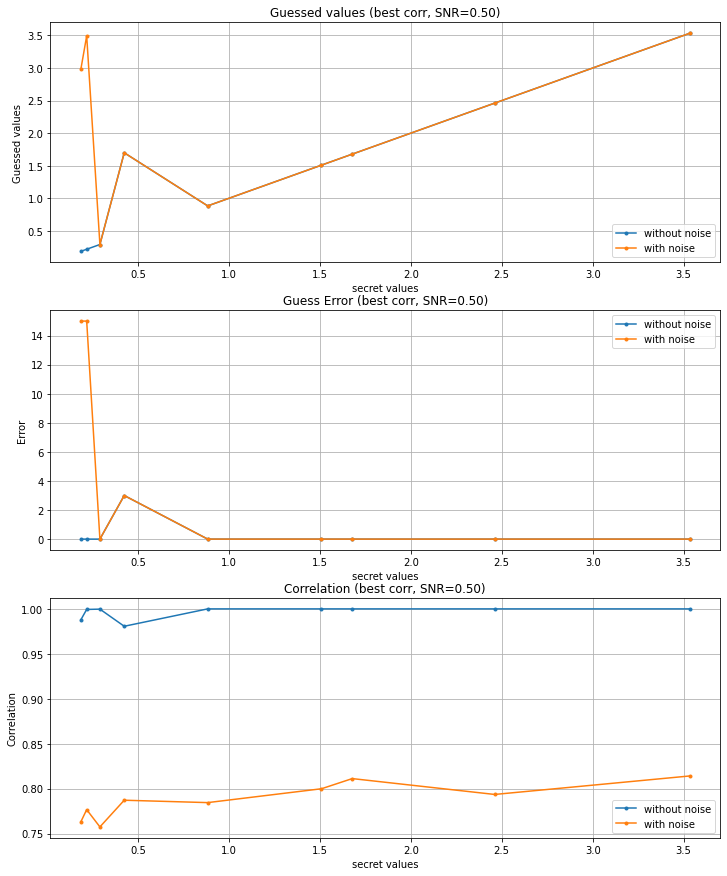

In [213]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(12, 15))
df = best_corr.T
df[[GUESSED_VALUE, SECRET_VALUE]].set_index(SECRET_VALUE)[GUESSED_VALUE].plot(ax=ax[0], marker='.', label='without noise')
df = noise_best_corr.T
df[[GUESSED_VALUE, SECRET_VALUE]].set_index(SECRET_VALUE)[GUESSED_VALUE].plot(ax=ax[0], marker='.', label='with noise')
ax[0].set_ylabel('Guessed values')
ax[0].set_title('Guessed values (best corr, SNR=%0.2f)' % signal_to_noise_ratio)

df = best_corr.T
df[[ERROR, SECRET_VALUE]].set_index(SECRET_VALUE)[ERROR].plot(ax=ax[1], marker='.', label='without noise')
df = noise_best_corr.T
df[[ERROR, SECRET_VALUE]].set_index(SECRET_VALUE)[ERROR].plot(ax=ax[1], marker='.', label='with noise')
ax[1].set_ylabel('Error')
ax[1].set_title('Guess Error (best corr, SNR=%0.2f)' % signal_to_noise_ratio)

df = best_corr.T
df[[CORRELATION, SECRET_VALUE]].set_index(SECRET_VALUE)[CORRELATION].plot(ax=ax[2], marker='.', label='without noise')
df = noise_best_corr.T
df[[CORRELATION, SECRET_VALUE]].set_index(SECRET_VALUE)[CORRELATION].plot(ax=ax[2], marker='.', label='with noise')
ax[2].set_ylabel('Correlation')
ax[2].set_title('Correlation (best corr, SNR=%0.2f)' % signal_to_noise_ratio)

for a in ax:
    a.legend()
    a.grid(True)
    a.set_xlabel('secret values')

from datetime import datetime
fname = 'nhw-%s.jpg' % (datetime.now().strftime("%Y%m%d_%H%M%S%f"))
plt.savefig(fname)
plt.show()

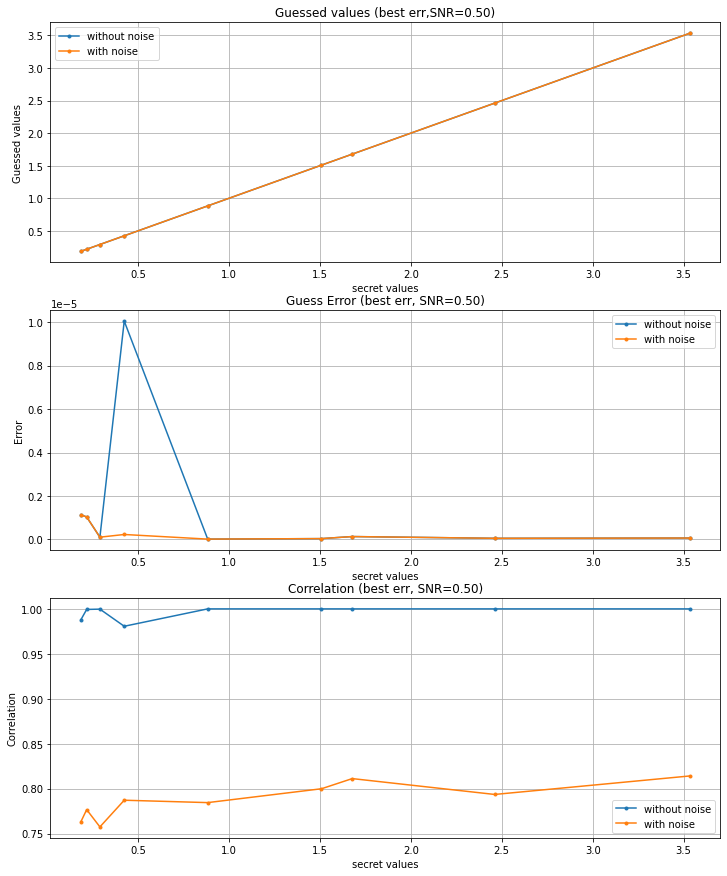

In [214]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(12, 15))
df = best_err.T
df[[GUESSED_VALUE, SECRET_VALUE]].set_index(SECRET_VALUE)[GUESSED_VALUE].plot(ax=ax[0], marker='.', label='without noise')
df = noise_best_err.T
df[[GUESSED_VALUE, SECRET_VALUE]].set_index(SECRET_VALUE)[GUESSED_VALUE].plot(ax=ax[0], marker='.', label='with noise')
ax[0].set_ylabel('Guessed values')
ax[0].set_title('Guessed values (best err,SNR=%0.2f)' % signal_to_noise_ratio)


df = best_err.T
df[[ERROR, SECRET_VALUE]].set_index(SECRET_VALUE)[ERROR].plot(ax=ax[1], marker='.', label='without noise')
df = noise_best_err.T
df[[ERROR, SECRET_VALUE]].set_index(SECRET_VALUE)[ERROR].plot(ax=ax[1], marker='.', label='with noise')
ax[1].set_ylabel('Error')
ax[1].set_title('Guess Error (best err, SNR=%0.2f)' % signal_to_noise_ratio)

df = best_corr.T
df[[CORRELATION, SECRET_VALUE]].set_index(SECRET_VALUE)[CORRELATION].plot(ax=ax[2], marker='.', label='without noise')
df = noise_best_corr.T
df[[CORRELATION, SECRET_VALUE]].set_index(SECRET_VALUE)[CORRELATION].plot(ax=ax[2], marker='.', label='with noise')
ax[2].set_ylabel('Correlation')
ax[2].set_title('Correlation (best err, SNR=%0.2f)' % signal_to_noise_ratio)

for a in ax:
    a.legend()
    a.grid(True)
    a.set_xlabel('secret values')

from datetime import datetime
fname = 'nhw-%s.jpg' % (datetime.now().strftime("%Y%m%d_%H%M%S%f"))
plt.savefig(fname)
plt.show()

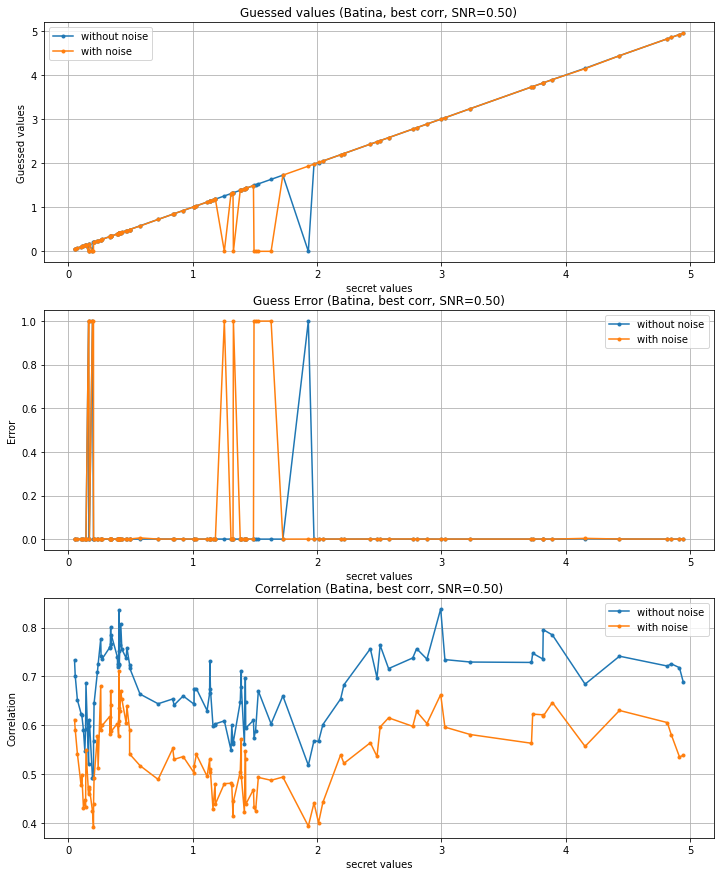

In [215]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(12, 15))
df = batina_best_corr.T
df[[GUESSED_VALUE, SECRET_VALUE]].set_index(SECRET_VALUE)[GUESSED_VALUE].plot(ax=ax[0], marker='.', label='without noise')
df = noise_batina_best_corr.T
df[[GUESSED_VALUE, SECRET_VALUE]].set_index(SECRET_VALUE)[GUESSED_VALUE].plot(ax=ax[0], marker='.', label='with noise')
ax[0].set_ylabel('Guessed values')
ax[0].set_title('Guessed values (Batina, best corr, SNR=%0.2f)' % signal_to_noise_ratio)

df = batina_best_corr.T
df[[ERROR, SECRET_VALUE]].set_index(SECRET_VALUE)[ERROR].plot(ax=ax[1], marker='.', label='without noise')
df = noise_batina_best_corr.T
df[[ERROR, SECRET_VALUE]].set_index(SECRET_VALUE)[ERROR].plot(ax=ax[1], marker='.', label='with noise')
ax[1].set_ylabel('Error')
ax[1].set_title('Guess Error (Batina, best corr, SNR=%0.2f)' % signal_to_noise_ratio)

df = batina_best_corr.T
df[[CORRELATION, SECRET_VALUE]].set_index(SECRET_VALUE)[CORRELATION].plot(ax=ax[2], marker='.', label='without noise')
df = noise_batina_best_corr.T
df[[CORRELATION, SECRET_VALUE]].set_index(SECRET_VALUE)[CORRELATION].plot(ax=ax[2], marker='.', label='with noise')
ax[2].set_ylabel('Correlation')
ax[2].set_title('Correlation (Batina, best corr, SNR=%0.2f)' % signal_to_noise_ratio)

for a in ax:
    a.legend()
    a.grid(True)
    a.set_xlabel('secret values')

from datetime import datetime
fname = 'nhw-%s.jpg' % (datetime.now().strftime("%Y%m%d_%H%M%S%f"))
plt.savefig(fname)
plt.show()